<h1><center>Avazu - Click-through prediction<center></h1>

# Overview

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding.
During this competition, participants were provided with 11 days worth of Avazu data to build and test prediction models. 

In [1]:
#IKmports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',200)

In [3]:
# Let us build a dataframe allowing to make a summary of the different models.
columns = ['Accuracy', 'Log Loss', 'ROC AUC']
index = ['Logit Xtrain_oh', 'Logit Xtrain_oh[:, cols_to_keep]', 'GradientBoosting Xtrain_oh[:, cols_to_keep]', 'Logit Xtrain with leafs', 'XGBoost Xtrain with leafs', 'XGBoost Xtrain with leafs 1024', 'Random Forest Xtrain with Hash', 'XGBoost Xtrain with Hash', 'XGBoost Xtrain with enlarge set', 'Random Forest Xtrain with enlarge set']
df_compare = pd.DataFrame(index = index, columns = columns,)

# The dataset

**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [4]:
df = pd.read_csv('../data/train-1000000')

In [5]:
df.head(10)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23
5,1.591127e+19,0,14102700,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,189590f9,2ea4f8ba,1,0,21611,320,50,2480,3,297,100111,61
6,4.149473e+18,0,14102408,1010,1,85f751fd,c4e18dd6,50e219e0,03a08c3f,7801e8d9,0f2161f8,192d98b0,74169322,c144e605,4,3,15704,320,50,1722,0,35,100084,79
7,1.085379e+19,0,14102904,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,342b6e9e,a0f5f879,1,0,23224,320,50,2676,0,35,100176,221
8,2.629918e+18,0,14102513,1010,1,85f751fd,c4e18dd6,50e219e0,8486dd4e,7801e8d9,0f2161f8,50dc7a55,2064d2cc,d6cd23ab,4,0,17875,320,50,2036,3,47,-1,156
9,1.419062e+19,0,14102600,1010,1,85f751fd,c4e18dd6,50e219e0,04f2be5f,7801e8d9,0f2161f8,feb99a64,72c47474,a0f5f879,4,3,22552,320,50,2602,0,163,100084,182


Let us first calculate the click through frequency in this dataset:

In [7]:
(df['click'].value_counts())/df['click'].describe()[0]
df['click'].mean()

0.169971

We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole dataset. We already know that a classifier always predicting `click`=0 will have good preformances in terms of error rate (around 0.17). The ROC and lift curves will be better performance metrics.

Moreover, we note that banner_pos, site_category, app_category, device_model, device_type, device_conn_type, C1, C14, C15, C16, C17, C18, C19, C20 and C21 all seem to be categorical features.

In [8]:
df.dtypes

id                  float64
click                 int64
hour                  int64
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
dtype: object

In [9]:
categorical = ['banner_pos', 'site_category', 'app_category', 'device_model', 'device_type', 'device_conn_type',
               'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [10]:
# displays the name of a variable, its unique values, and the number of its unique values 
for var in categorical: 
    print(var, df[var].unique(), df[var].nunique())

banner_pos [1 0 7 2 4 5 3] 7
site_category ['f028772b' '50e219e0' '28905ebd' '3e814130' '75fa27f6' '76b2941d'
 'f66779e6' '72722551' '0569f928' '335d28a8' 'c0dd3be3' '70fb0e29'
 '8fd0aea4' 'dedf689d' 'e787de0e' '42a36e14' 'a818d37a' '9ccfa2ea'
 'bcf865d9' '5378d028' 'da34532e' 'c706e647'] 22
app_category ['07d7df22' 'cef3e649' '0f2161f8' '8ded1f7a' 'f95efa07' 'dc97ec06'
 '09481d60' 'd1327cf5' 'fc6fa53d' '2281a340' '7113d72a' '4681bb9d'
 '75d80bbe' '0f9a328c' '4ce2e9fc' 'a3c42688' 'a7fd01ec' '879c24eb'
 'a86a3e89' '8df2e842' '18b1e0be' '86c1a5a3' '2fc4f2aa' '79f0b860'
 '0bfbc358' '5326cf99'] 26
device_model ['be87996b' '7e6190f3' '3c55fad5' ... 'cbc27e50' '8441e5e4' '78cd4bd4'] 5168
device_type [1 0 4 5 2] 5
device_conn_type [2 0 3 5] 4
C1 [1005 1002 1010 1007 1012 1001 1008] 7
C14 [ 4687 17894 22684 ... 22667 22660 18579] 2243
C15 [ 320  300  216  728  120  768 1024  480] 8
C16 [  50  250   36  480   90   20 1024  768  320] 9
C17 [ 423 2039 2619 2676  761 2480 1722 2036 2602 2545 2494 

Given these categorical variables, one-hot encoding might make sense, but we must figure out the numer of columns this would create first:

In [11]:
m, n = df.shape
non_categorical = n - len(categorical)

res = 0
for var in categorical:
    res += df[var].nunique()
print('Size of the categorical features in dummies encoding:',res)

Size of the categorical features in dummies encoding: 8212


In [12]:
print(f'The dimension with all categorical variables in dummies encoding: {res + non_categorical}')

The dimension with all categorical variables in dummies encoding: 8221


To avoid any issues related with date formats, let us have a look at the 'hour' column: 

In [13]:
print('Type:', df['hour'].dtype)

Type: int64


In [14]:
print(df['hour'].head()) 
print(df['hour'].tail())

# It could also be done like so:
# df['new_hour'] = pd.to_datetime(df['hour'].astype('str'), format = '%y%m%d%H')
# df['new_hour'].head(5)

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


For example for '_14102915_', the year, the month, the day and hour are:
* Year : 14 => 2014 
* Month : 10 
* Day : 29 
* Hour : 15 

Since ```hour``` is an integer, it can be sliced like a string and it is easy with slicing operations to return the year, the month, the day and the hour.

In [15]:
# We can simply transform this feature:
df['new_hour'] = pd.to_datetime(df['hour'].astype('str'), format = '%y%m%d%H')
df['new_hour'].head(5)

0   2014-10-29 15:00:00
1   2014-10-30 07:00:00
2   2014-10-27 11:00:00
3   2014-10-29 03:00:00
4   2014-10-29 02:00:00
Name: new_hour, dtype: datetime64[ns]

In [16]:
df.drop(columns = ['new_hour'], inplace= True)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23


To simplify the work, let us perform the following transformation to the column:
 - The input variable `hour` which is a _string_ is transformed into a variable of _date_ type. It's done by taking the first two caracters of the string as the year, the 3rd and 4th caracter as the month and so on. 
 - This function return an object which have methods that give the hour or the day of the week..  

In [17]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

In [18]:
datesplit(14102915)

datetime.datetime(2014, 10, 29, 15, 0)

 - The input variable `hour` which is a _string_ is transformed into a variable of _date_ type. It's done by taking the first two caracters of the string as the year, the 3rd and 4th caracter as the month and so on. 
 - This function return an object which have methods that give the hour or the day of the week..  

Let us now create a 'weekday' columns, and replace the 'hour' column by the hour.

In [19]:
df['weekday'] = df['hour'].apply(lambda x: datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x: datesplit(x).hour)

In [20]:
df['weekday'].head()

0    2
1    3
2    0
3    2
4    2
Name: weekday, dtype: int64

Now, let us try to visualize the influence of the hour and of the day on the 'click' frequency. To do so, we plot 'click' vs 'hour' and 'click' vs 'weekday' curves.

Click vs Hour: AxesSubplot(0.125,0.125;0.352273x0.755)
Click vs Weekday: AxesSubplot(0.547727,0.125;0.352273x0.755)


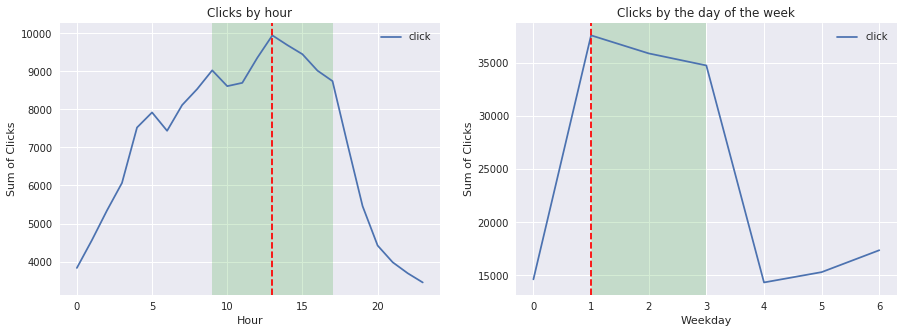

In [21]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
print('Click vs Hour:', df.groupby(['hour'])['click'].sum().plot())
hourMax = df.groupby(['hour'])['click'].sum().idxmax()
plt.axvline(x = hourMax, linestyle='--', color = 'r')
plt.axvspan(9, 17, facecolor='#2ca02c', alpha=0.2)
plt.xlabel("Hour")
plt.ylabel("Sum of Clicks")
plt.title('Clicks by hour')
plt.legend()

plt.subplot(1, 2, 2)
print('Click vs Weekday:', df.groupby(['weekday'])['click'].sum().plot())
dayMax = df.groupby(['weekday'])['click'].sum().idxmax()
plt.axvline(x = dayMax, linestyle='--', color = 'r')
plt.axvspan(1, 3, facecolor='#2ca02c', alpha=0.2)
plt.title('Clicks by the day of the week')
plt.xlabel("Weekday")
plt.ylabel("Sum of Clicks")
plt.legend()

plt.show()

* There are more clicks between 8am and 5pm, which are the usual work hours. There is an increase of the clicks between 11am and 1pm, which is the lunch break. 

* Tuesday, Wednesday and Thursday are the days with the highest number of clicks. The week-end is the period in the week where the clicks are the lowest with a significant decrease. 

In the first graph, the Y axe stands for the sum of clicks depending on X, which is the hour of the day. The second one, plots the sum of clicks on the day of the week. 

The following graphs show the histograms of the weekday and the hour in the datasets. Since the dataset includes 11 days of data, with the following graphs,Tuesday, Wednesday and Thursday are represented twice. 

We can see that the number of clicks reaches its maximum around 1pm on Tuesdays.

The number of clicks increases in the time range from 9am to 5pm, i.e. during office hours. This is confirmed by the number of clicks per day of the week, where there is a sharp increase from Tuesday to Thursday.

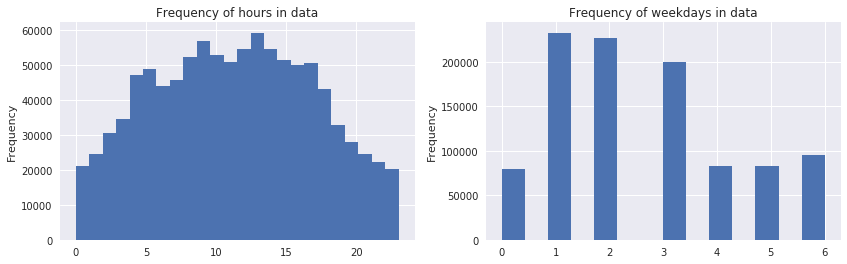

In [22]:
plt.figure(1, figsize=(14, 4))

plt.subplot(1, 2, 1)
df['hour'].plot(kind= "hist", bins= 24, title= 'Frequency of hours in data')

plt.subplot(1, 2, 2)
df['weekday'].plot(kind= "hist", bins= 14, title= 'Frequency of weekdays in data')

plt.show()

# Preliminary work and first model

Now, we would like to better undertand the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

For instance, let's inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.

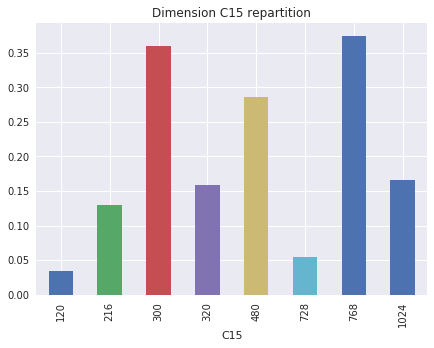

In [23]:
plt.figure(1, figsize=(7, 5))
df.groupby(['C15'])['click'].mean().plot(kind = 'bar')
plt.title('Dimension C15 repartition')
plt.show()

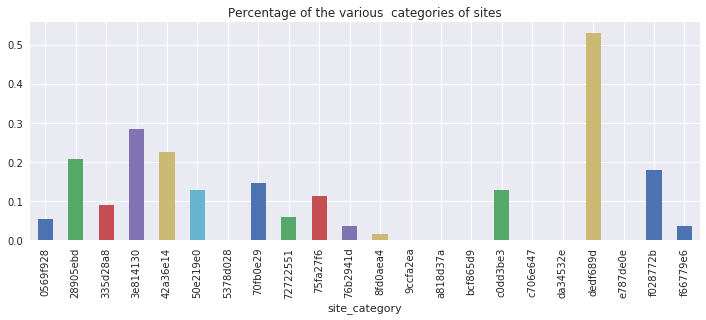

In [24]:
plt.figure(1, figsize=(12, 4))
df.groupby(['site_category'])['click'].mean().plot(kind = 'bar')
plt.title('Percentage of the various  categories of sites')
plt.show()

- It can be seen that the site category 'dedf689d' is much more present than the other site categories.

Interestingly enough, some site categories have a null click rate:

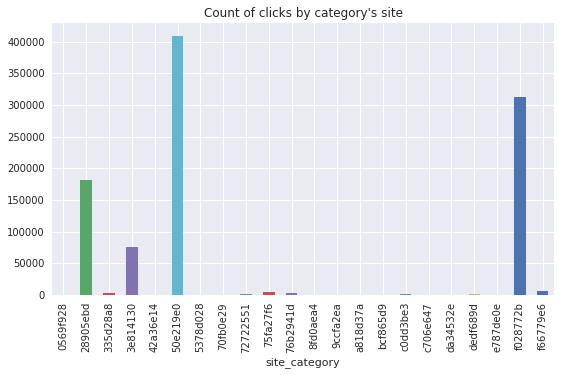

In [25]:
plt.figure(1, figsize = (9, 5))
df.groupby(['site_category'])['click'].count().plot(kind = 'bar')
plt.title('Count of clicks by category\'s site')
plt.show()

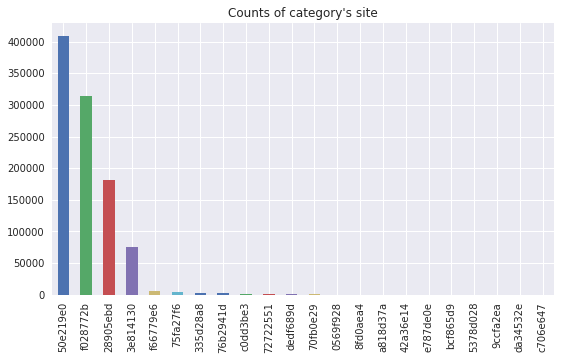

In [26]:
plt.figure(1, figsize = (9, 5))
df['site_category'].value_counts().plot(kind = 'bar')
plt.title('Counts of category\'s site')
plt.show()

* We can see that clicks are mainly concentrated on 4 categories of sites in particular. 
* However, we find (in the same order) that these same categories are also the most present in the data set.
* A large number of site categories are very poorly represented in the dataset so these categories also have a nearly zero click rate.

* One possible explanation could be that the four categories could be online clothing, technology or market places websites. The others categories could be non targeted ads that only few people click on.

It is practical to visualize both columns in parallel:

In [27]:
col = 'C1'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False)

,mean,count
C1,,
1005,0.169474,918606.0
1002,0.211157,54907.0
1010,0.095497,22409.0
1012,0.177295,2854.0
1007,0.035591,871.0
1001,0.027027,222.0
1008,0.106870,131.0


Now, let us divide the dataset into a training (90%) and test set (10%):

In [28]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df.loc[:, df.columns != 'click'], df['click'], 
                                                test_size=0.1, random_state=100)

# First work on a reduced number of features

We put in a list the features that seem most relevant so far, i.e.: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

In [29]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

df[some_columns].head()

,hour,weekday,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,C21
0,15,2,1005,1,f028772b,07d7df22,1,2,320,50,2,32
1,7,3,1002,0,50e219e0,07d7df22,0,0,320,50,2,32
2,11,0,1005,0,50e219e0,cef3e649,1,0,320,50,1,71
3,3,2,1005,0,50e219e0,0f2161f8,1,0,320,50,0,221
4,2,2,1005,1,f028772b,07d7df22,1,0,320,50,3,23


In [30]:
df.columns 

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday'],
      dtype='object')

The, we transform these columns using one-hot encoding:

In [31]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
Xtrain_oh = ohe.fit(Xtrain[some_columns])
Xtrain_oh = ohe.transform(Xtrain[some_columns])
Xtest_oh = ohe.transform(Xtest[some_columns])

print('type Xtrain_oh :',type(Xtrain_oh))
print('type Xtest_oh:',type(Xtest_oh))

type Xtrain_oh : <class 'scipy.sparse.csr.csr_matrix'>
type Xtest_oh: <class 'scipy.sparse.csr.csr_matrix'>


The output is a sparse matrix.

In [32]:
print("The new number of features is", Xtrain_oh.shape[1])

The new number of features is 183


Let's have a look at the first row of the design matrix:

In [33]:
print(Xtrain_oh[0])

  (0, 10)	1.0
  (0, 24)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (0, 50)	1.0
  (0, 70)	1.0
  (0, 96)	1.0
  (0, 100)	1.0
  (0, 105)	1.0
  (0, 112)	1.0
  (0, 119)	1.0
  (0, 145)	1.0


Let us try first a simple model (logistic regression) on the encoded data

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain_oh, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We can then display the hard and soft decision you get on test data.

In [35]:
hard = lr.predict(Xtest_oh)
soft = lr.predict_proba(Xtest_oh)

print('Hard Decision:')
print(hard)
print('Soft Decision:')
print(soft)

Hard Decision:
[0 0 0 ... 0 0 0]
Soft Decision:
[[0.75809672 0.24190328]
 [0.73399737 0.26600263]
 [0.79688723 0.20311277]
 ...
 [0.79253193 0.20746807]
 [0.7856205  0.2143795 ]
 [0.87849724 0.12150276]]


In [36]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ytest, hard)
print(f"The accuracy score of the model is {np.round(1 - accuracy, 2)}")

The accuracy score of the model is 0.17


The probability of classifying inputs wrongly is 0.17, which is also the true frequency of clicks ie `click = 1` or the mean. Therefore the error shows that the logistic model doesn't do better than always predicting no click at all. This is a consequence of the imbalance in the labels.

`AUC` and `log likelihood` could be better metrics to estimate the validity of the models. 

Let's plot the ROC curve, and compute the log loss and the area under the ROC curve.
</font>

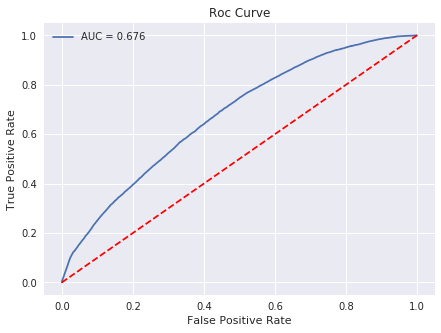

In [37]:
from sklearn.metrics import roc_curve, auc

# calculate the fpr and tpr for all thresholds of the classification
preds = soft[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (7, 5))
plt.title('Roc Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import log_loss , roc_auc_score 

print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83043
The log loss is equal to : 0.42512
The Area Under the Curve ROC is equal to: 0.67628


In [39]:
df_compare['Accuracy']['Logit Xtrain_oh'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['Logit Xtrain_oh'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['Logit Xtrain_oh'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

Alternatively, we can also plot the lift curve:

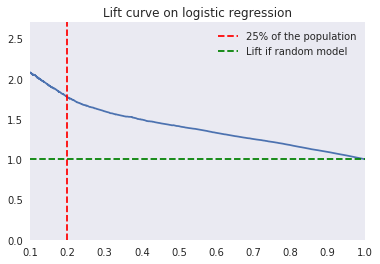

In [40]:
from utils import plotlift
plotlift(ytest, soft[:, 1])
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2, linestyle='--', color='r', label= "25% of the population") # Fill here
plt.axhline(y= 1, linestyle='--', color='g', label= "Lift if random model")
plt.title("Lift curve on logistic regression")
plt.legend()
plt.show()

Lift curve is a way to visualize the performance of a classification model compared to the average response.
The lift score is:

$lift = \frac{predicted\ click\ rate}{average\ click\ rate}$

The lift score for 20% of the population is 1.75, which means that if a marketing campaign is done on this group, the expected click rate could be 1.5 times larger than the click rate done on the average population.
The lift score therefore shows that the logistic model does better than random, which was not shown by the acurracy score. 

# Complete model

As an example, we now work on the 'site_id' column. For each modality, we compute the number of occurrences in the dataset and the average of clicks for this modality, then we represent the set of points (count, mean) for each modality:

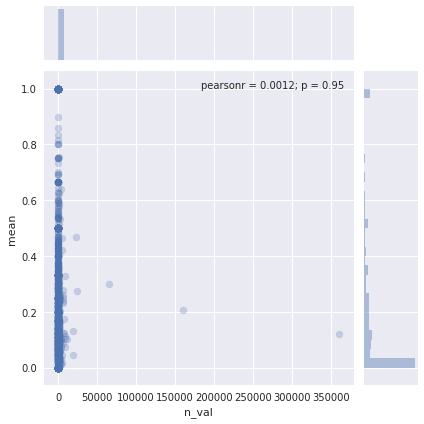

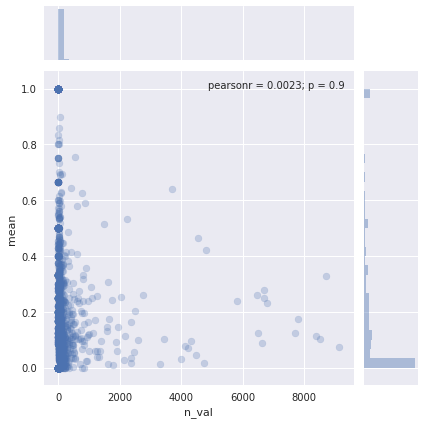

In [41]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25)
plt.show()

The first graph shows that there are outliers in site ids, hence, the second graph is done by creating a threshold to better visualize the data. 

One site id is particularly overrepresented compared to the other site ids. 

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.
<font color="red">**Question 25:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

Now let's do the same work on the 'device_id' column:

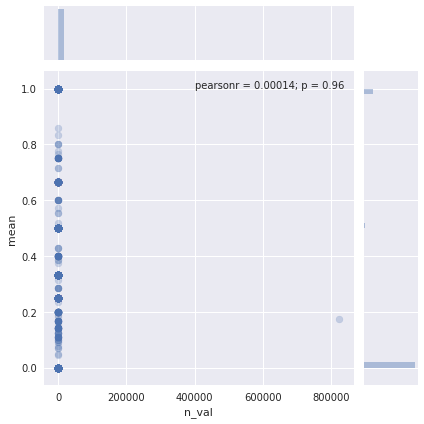

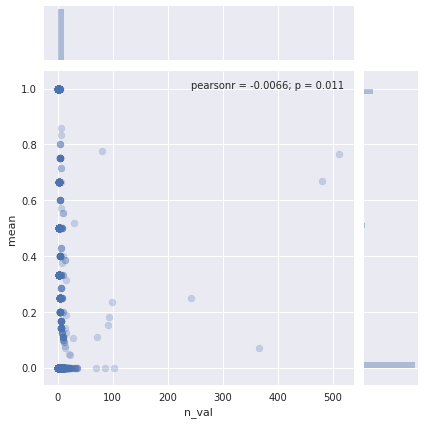

In [42]:
col = "device_id"
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

In [43]:
df['device_id'].value_counts().head()

a99f214a    824918
0f7c61dc       512
c357dbff       481
936e92fb       366
afeffc18       242
Name: device_id, dtype: int64

In [44]:
df.loc['device_id' == 'a99f214a']

id                  3.98321e+18
click                         0
hour                         15
C1                         1005
banner_pos                    1
site_id                e151e245
site_domain            7e091613
site_category          f028772b
app_id                 ecad2386
app_domain             7801e8d9
app_category           07d7df22
device_id              a99f214a
device_ip              fb6566d3
device_model           be87996b
device_type                   1
device_conn_type              2
C14                        4687
C15                         320
C16                          50
C17                         423
C18                           2
C19                          39
C20                      100148
C21                          32
weekday                       2
Name: 0, dtype: object

In 'device_id' there is again an outlier which is visualized on the first graph by the point in the far right, which is an isolated point. This point could be a bot, or maybe a generic label applied to all devices whose browsing history is unknown.

 The second graph represents the data without outliers by putting a threshold. It shows that one device_id has a significantly higher number of occurence.  

In the column df['device_id'], we would like to spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:

$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [45]:
V = df['device_id'].value_counts().index[0] # a99f214a

condlist = [df['device_id'] != V, df['device_id'] == V]
choicelist = [df['device_id'], df['device_ip']+df['device_model']]
df['user'] = np.select(condlist, choicelist)
df['user'].head()

0    fb6566d3be87996b
1            9b7af851
2    748e298a3c55fad5
3    a50da3d4c5cc73c1
4    d5f88679a5bce124
Name: user, dtype: object

Let's drop a few unnecessary columns:

In [46]:
df.drop(columns = ['device_id', 'device_model', 'device_ip'], inplace= True)
df.columns.values # to check that the columns are deleted

array(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id',
       'site_domain', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15',
       'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user'],
      dtype=object)

We'd like to investigate the similarity between 'site_id' and 'site_domain'. To do so, let us merge these columns into a new 'site' column and delete the old 'site_id' and 'site_domain' columns.
</font>

In [47]:
df['site_id'].value_counts().head()

85f751fd    360911
1fbe01fe    159924
e151e245     65231
d9750ee7     24090
5b08c53b     22524
Name: site_id, dtype: int64

In [48]:
df['site_domain'].value_counts().head()

c4e18dd6    374158
f3845767    159924
7e091613     82263
7687a86e     31858
98572c79     24879
Name: site_domain, dtype: int64

In [49]:
# we can see that the frequency for these two variables is quite similar
df['site'] = df['site_id'] + df['site_domain']
df.drop(columns = ['site_id', 'site_domain'], inplace= True)
df.columns.values

array(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'weekday', 'user', 'site'], dtype=object)

Again, we split the modified DataFrame df into a train (90%) and a test set (10%) (with option: random_state = 100).
</font>

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.loc[:, df.columns != 'click'], df['click'], test_size=0.1, random_state=100)
print(Xtrain.shape, Xtest.shape)

(900000, 21) (100000, 21)


Then we perform one-hot encoding:

In [51]:
ohe = OneHotEncoder(handle_unknown= 'ignore')
Xtrain_oh = ohe.fit_transform(Xtrain)
Xtrain_oh.shape

(900000, 1613334)

In [53]:
print(f'The new number of features is: {Xtrain_oh.shape[1]}.')

The new number of features is: 1613334.


How many modalities have been seen more than a 100 times?
</font>

In [54]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array((Xtrain_oh != 0).sum(0))[0]
sum(n_ones > 100)

1971

There are 1971 modalities occurring more than 100 times in the initial 1613334 modalities.

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times.

In [55]:
cols_to_keep = []
for counter, value in enumerate(n_ones):
    if value > 100:
        cols_to_keep.append(counter)

Using only our restriction on the 'cols_to_keep' columns, let's retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [56]:
# Retrain logistic regression with selected columns.
clf = LogisticRegression()
clf.fit(Xtrain_oh[:, cols_to_keep], ytrain)
hard = clf.predict(Xtest_oh[:, cols_to_keep])
soft = clf.predict_proba(Xtest_oh[:, cols_to_keep])

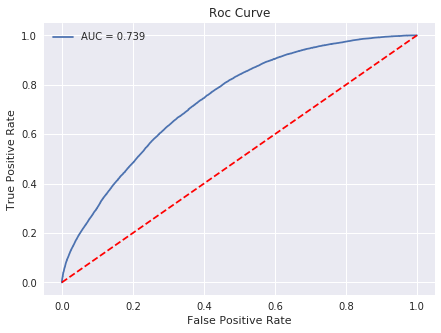

In [57]:
# calculate the fpr and tpr for all thresholds of the classification
preds = soft[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (7, 5))
plt.title('Roc Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [58]:
df_compare['Accuracy']['Logit Xtrain_oh[:, cols_to_keep]'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['Logit Xtrain_oh[:, cols_to_keep]'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['Logit Xtrain_oh[:, cols_to_keep]'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

In [59]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83375
The log loss is equal to : 0.40116
The Area Under the Curve ROC is equal to: 0.7386


The log loss of the previous model was 0.40116 and the ROC AUC score was 0.7386. Therefore, this model with one hot encoders and 1971 features has better performance since the log loss of the last model is lower.

# Gradient Boosting Decision Trees

Now, we are going to:
    - Import GradientBoostingClassifier from scikit learn. 
    - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the algorithm.
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    - Evaluate its performance as in the previous step.
</font>

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators= 50, learning_rate= 0.8, verbose= True)
gb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8743            3.73m
         2           0.8646            3.60m
         3           0.8583            3.53m
         4           0.8535            3.43m
         5           0.8503            3.34m
         6           0.8464            3.26m
         7           0.8441            3.19m
         8           0.8418            3.11m
         9           0.8404            3.04m
        10           0.8383            2.96m
        20           0.8282            2.23m
        30           0.8234            1.49m
        40           0.8190           44.68s
        50           0.8163            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [61]:
soft = gb.predict_proba(Xtest_oh[:, cols_to_keep])
hard = gb.predict(Xtest_oh[:, cols_to_keep])

In [62]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83344
The log loss is equal to : 0.40916
The Area Under the Curve ROC is equal to: 0.72524


In [63]:
df_compare['Accuracy']['GradientBoosting Xtrain_oh[:, cols_to_keep]'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['GradientBoosting Xtrain_oh[:, cols_to_keep]'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['GradientBoosting Xtrain_oh[:, cols_to_keep]'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

gb.estimators_ ouputs an array with the estimator fitted in each iteration -here there are 50 iterations. 

In [64]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f10f40fbcf0>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f10f40fbcf0>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, 

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.
To do so, we generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the nth column corresponds to the number of the leaf returned by the estimator n.

In [65]:
gb.apply(Xtrain_oh[:, cols_to_keep])
# shape : (900000, 50, 1)
# type : ndarray
# Apply trees in the ensemble to X, return leaf indices.

array([[[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       ...,

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [13.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]]])

In [66]:
leafs_train = gb.apply(Xtrain_oh[:, cols_to_keep])
leafs_test = gb.apply(Xtest_oh[:, cols_to_keep])
print(leafs_train.shape)

(900000, 50, 1)


In [67]:
leafs_train = pd.DataFrame(np.reshape(leafs_train, (leafs_train.shape[0], leafs_train.shape[1]))) 
leafs_test = pd.DataFrame(np.reshape(leafs_test, (leafs_test.shape[0], leafs_test.shape[1])))
print(leafs_train.shape, leafs_test.shape)

(900000, 50) (100000, 50)


We can then encode these new features into dummies.
</font>

In [68]:
ohe = OneHotEncoder(sparse= False, categories='auto')
leafs_train_oh = ohe.fit_transform(leafs_train)
leafs_test_oh =  ohe.transform(leafs_test)

In [69]:
print(leafs_train_oh.shape, leafs_test_oh.shape)

(900000, 396) (100000, 396)


Then, with the "hstack" function, we create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").

In [70]:
from scipy.sparse import csr_matrix, hstack

Xtrain_concat = hstack([leafs_train_oh, Xtrain_oh[:, cols_to_keep]]) # Fill here
Xtest_concat =  hstack([leafs_test_oh, Xtest_oh[:, cols_to_keep]])
print(Xtrain_concat.shape, Xtest_concat.shape)

(900000, 2367) (100000, 2367)


In [71]:
print(type(Xtrain_concat))

<class 'scipy.sparse.coo.coo_matrix'>


Then we run a logistic regression on the new features and evaluate its performance as before.
</font>

In [72]:
lgt = LogisticRegression()
lgt.fit(Xtrain_concat, ytrain)
soft = lgt.predict_proba(Xtest_concat)
hard = lgt.predict(Xtest_concat)

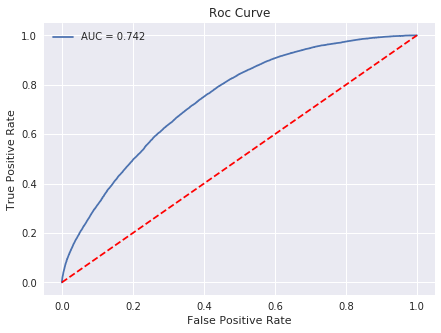

In [73]:
preds = soft[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (7, 5))
plt.title('Roc Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [74]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83409
The log loss is equal to : 0.39993
The Area Under the Curve ROC is equal to: 0.74177


In [75]:
df_compare['Accuracy']['Logit Xtrain with leafs'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['Logit Xtrain with leafs'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['Logit Xtrain with leafs'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

Let us now try a more sophisticated classifier (XGBoost):

In [76]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators= 50, learning_rate= 0.8, verbose= True, n_jobs= -1)
%time xgb.fit(Xtrain_concat, ytrain)
soft = xgb.predict_proba(Xtest_concat)
hard = xgb.predict(Xtest_concat)
# 6 / 28.5 wall time
# 3, 5 / 28.3
# 1 : 36

CPU times: user 2min 21s, sys: 6.47 s, total: 2min 28s
Wall time: 35.6 s


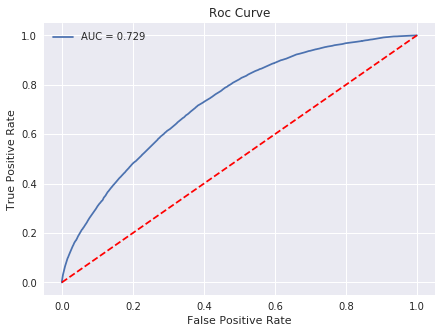

In [77]:
preds = soft[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (7, 5))
plt.title('Roc Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [78]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83348
The log loss is equal to : 0.40623
The Area Under the Curve ROC is equal to: 0.72903


In [79]:
df_compare['Accuracy']['XGBoost Xtrain with leafs'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['XGBoost Xtrain with leafs'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['XGBoost Xtrain with leafs'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

Now let's try some fine tuning, by adapting the number of estimators and the learning rate:

> With learning rate = 0.8
- The accuracy of the model is: 0.833
- The log loss is equal to : 0.406
- The ROC AUC score: 0.73

> With learning_rate = 0.01
- The accuracy of the model is: 0.831
- The log loss is equal to : 0.417
- The ROC AUC score: 0.707

> With learning_rate = 0.001
- The accuracy of the model is: 0.83
- The log loss is equal to : 0.477
- The ROC AUC score: 0.668

> With learning_rate = 0.06
- The accuracy of the model is: 0.83404
- The log loss is equal to : 0.39824
- The Area Under the Curve ROC is equal to: 0.74495


We notice that we have the best score with a learning rate of 0.6.

In [80]:
xgb = XGBClassifier(n_estimators= 1024, learning_rate= 0.6, n_jobs= -1)
%time xgb.fit(Xtrain_concat, ytrain)

CPU times: user 41min 11s, sys: 1min 43s, total: 42min 54s
Wall time: 5min 39s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1024,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [81]:
soft = xgb.predict_proba(Xtest_concat)
hard = xgb.predict(Xtest_concat)

In [82]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83406
The log loss is equal to : 0.39857
The Area Under the Curve ROC is equal to: 0.7444


In [83]:
df_compare['Accuracy']['XGBoost Xtrain with leafs 1024'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['XGBoost Xtrain with leafs 1024'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['XGBoost Xtrain with leafs 1024'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

Adding more estimators means that there are more trees added to the model. There is an inverse relationship between n_estimators and the learning_rate to avoid overfitting. 

# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.

In [84]:
print(Xtrain.shape, Xtest.shape)

(900000, 21) (100000, 21)


We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self
 
    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


* `rare_indexes` returns the indexes for modalities which counts are lower than a given threshold. These observations are labeled as rare.

* `frequent_indexes` returns the indexes for modalities which counts are higher or equal to a given threshold. Theses observations are labeled as frequent.

* The dictionnary `counts_dict_list` is a dictionnary with indexes as keys and values are either "isRare"  if it is in `rare_indexes` or the value is the index if it is in `frequent_indexes`. 

* In the `transform`, it creates Xt, which is a pandas DataFrame. This function transforms the initial design matrix X such that for each row, if it's not in `zip(self.col_names, self.counts_dict_list_)` then it is labelled as `isRare`, else the initial row from X is copied. 

Now we can fit and transform the training set. To do so, we merge all modalities occuring at least 20 times in each column.Then we transform the test set.
</font>

In [86]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain)
Xtest_mg = mg.transform(Xtest)
print(Xtrain_mg.shape, Xtest_mg.shape)

(900000, 21) (100000, 21)


Let us see how many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare':

In [87]:
print(Xtrain_mg.groupby(['app_domain'])['id'].value_counts())

app_domain  id    
0654b444    isRare       514
0d79ee56    isRare        53
0e8616ad    isRare     14784
15c23f8e    isRare        25
15ec7f39    isRare       275
18eb4e75    isRare        56
1ea19ec4    isRare        72
1ed56ded    isRare        27
2347f47a    isRare    116467
27ee373d    isRare        36
2b627705    isRare        89
33da2e74    isRare      5911
3feeed1e    isRare        26
43cf4f06    isRare       149
448ca2e3    isRare       167
45a51db4    isRare      1219
47464e95    isRare        99
5ac0b939    isRare        28
5b9c592b    isRare      2448
5c5a694b    isRare     25289
5c620f04    isRare      1419
63f57be0    isRare        25
6a0a3a9d    isRare        59
6f7ca2ba    isRare      4990
7801e8d9    isRare    606390
7a9371fa    isRare        21
7eec2ab0    isRare        24
813f3323    isRare       544
828da833    isRare       185
82e27996    isRare     16869
885c7f3f    isRare      1468
99b4c806    isRare       219
9ec164d3    isRare        51
a8b0bf20    isRare      

In [88]:
isRare = Xtrain_mg.query("app_domain == 'isRare'")['app_domain'].count()
print(f'The "app_domain column" has {isRare} labelled observations as "isRare".')

The "app_domain column" has 513 labelled observations as "isRare".


In the new train set, the number of modalities for each feature is as follows:

In [89]:
tmp = Xtrain_mg.columns.values
tmp2 = []
for var in tmp:
    print(var, Xtrain_mg[var].nunique())
    tmp2.append(Xtrain_mg[var].nunique())

id 1
hour 24
C1 7
banner_pos 7
site_category 18
app_id 613
app_domain 53
app_category 19
device_type 5
device_conn_type 4
C14 1339
C15 8
C16 9
C17 381
C18 4
C19 63
C20 148
C21 60
weekday 7
user 901
site 889


Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transorm them into integers with the hashing trick. To better understand how the 'hash' function is working, we apply it to some string.

In [90]:
import hashlib
hash('hashlib') # Fill here

2719253290376222919

The hashlib function has as an input a string and returns a fixed lenghth sequence of numbers. 

We can thus create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. We use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>

In [91]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x: hash(x)%1000000)  
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x: hash(x)%1000000)

In [92]:
display("Xtrain_ha", Xtrain_ha.head())
display("Xtest_ha", Xtest_ha.head())

'Xtrain_ha'

,id,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,651001,356800,722883,308882,67389,708206,152519,676104,728304,661989,496096,667711,597520,171462,772298,876307,133483,228935,772298,651001,991351
60898,651001,132498,758049,772298,67389,184509,222881,714039,308882,595783,496096,667711,597520,171462,772298,876307,133483,228935,308882,651001,991351
556199,651001,728304,758049,772298,693137,663626,152519,482402,308882,595783,932631,667711,597520,401646,772298,68222,133483,32359,772298,651001,443385
193129,651001,174384,758049,308882,693137,663626,152519,482402,308882,772298,60330,667711,597520,296341,772298,200130,58156,78702,308882,651001,206459
231985,651001,145351,758049,772298,284485,663626,152519,482402,308882,772298,343520,667711,597520,171462,772298,876307,835254,228935,207933,651001,117175


'Xtest_ha'

,id,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
617759,651001,207933,758049,308882,693137,663626,152519,482402,308882,772298,240805,667711,597520,795573,595783,901675,133483,818821,661989,651001,727727
693227,651001,356800,758049,772298,284485,663626,152519,482402,308882,772298,132631,667711,597520,195965,595783,603214,246131,748127,595783,651001,353872
906065,651001,927192,758049,308882,693137,663626,152519,482402,308882,772298,337718,667711,597520,903537,661989,876307,915223,145351,252995,651001,206459
828507,651001,207933,758049,772298,67389,596908,222881,676104,308882,772298,425277,667711,597520,472774,661989,664581,663082,560186,661989,651001,991351
869730,651001,356800,765578,772298,67389,663626,152519,482402,772298,772298,580962,667711,597520,978859,595783,901675,133483,818821,595783,651001,51032


Now we can train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. We chose 1024 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step.
    <br>
</font>

In [93]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(n_estimators= 1024, min_samples_leaf= 20, verbose= 1, n_jobs= -1)
%time rf.fit(Xtrain_ha, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.5min


CPU times: user 50min 8s, sys: 6min 55s, total: 57min 3s
Wall time: 7min 9s


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  7.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1024, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [94]:
soft = rf.predict_proba(Xtest_ha)
hard = rf.predict(Xtest_ha)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 1024 out of 1024 | elapsed:    6.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 1024 out of 1024 | elapsed:    6.9s finished


In [95]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83353
The log loss is equal to : 0.40103
The Area Under the Curve ROC is equal to: 0.74117


In [96]:
df_compare['Accuracy']['Random Forest Xtrain with Hash'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['Random Forest Xtrain with Hash'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['Random Forest Xtrain with Hash'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

Let us compare it with xgboost performance on the same hashed dataset.
</font>

In [97]:
xgb = XGBClassifier(n_estimators= 1024, min_samples_leaf= 20, learning_rate= 0.6, verbose= 1, n_jobs= -1) # Fill here
%time xgb.fit(Xtrain_ha, ytrain) # the '%time' command will return the execution time of the fitting step

CPU times: user 18min 14s, sys: 2min, total: 20min 14s
Wall time: 2min 31s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=20, missing=None,
       n_estimators=1024, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbose=1)

In [98]:
soft = xgb.predict_proba(Xtest_ha)
hard = xgb.predict(Xtest_ha)

In [99]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.8347
The log loss is equal to : 0.39802
The Area Under the Curve ROC is equal to: 0.74554


In [100]:
df_compare['Accuracy']['XGBoost Xtrain with Hash'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['XGBoost Xtrain with Hash'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['XGBoost Xtrain with Hash'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

And we plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data).
</font>

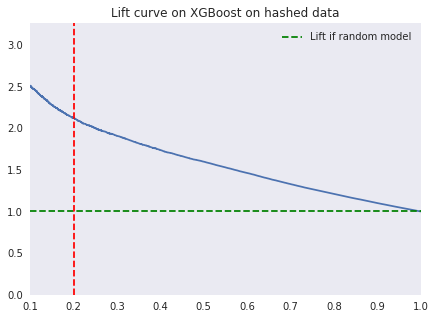

In [101]:
# Plot the lift curve
plt.figure(1, figsize = (7, 5))
plotlift(ytest, soft[:,1])
plt.axhline(y= 1, linestyle='--', color='g', label= "Lift if random model")
plt.title("Lift curve on XGBoost on hashed data")
plt.axvline(x = 0.2 , linestyle='--', color='r') 
plt.legend()
plt.show()

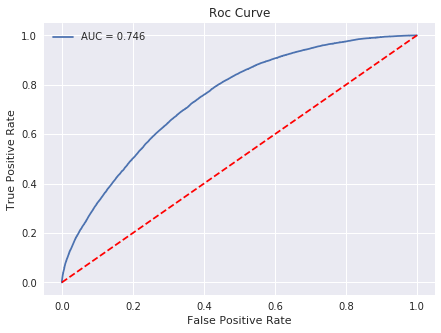

In [102]:
preds = soft[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (7, 5))
plt.title('Roc Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. So we add hashed columns by recursively hashing the previous ones: complete the following code.

In [103]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha = pd.DataFrame(Xtest_ha).copy()

n_hash = 1
cols = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply(lambda x: hash(str(x))%1000000)
        Xtest_haha[col + '-hash'] = Xtest_haha[col].apply(lambda x: hash(str(x))%1000000)
    cols = [col + '-hash' for col in cols]

Now let us evaluate the performance of a random forest and/or an xgboost clasifier on these enlarged dataset.
</font>

### XGBoost  Classifier:

In [104]:
xgb = XGBClassifier(n_estimators= 1024, min_samples_leaf= 20, learning_rate= 0.6, n_jobs= -1) # Fill here
%time xgb.fit(Xtrain_haha, ytrain) # the '%time' command will return the execution time of the fitting step

CPU times: user 33min 10s, sys: 2min, total: 35min 11s
Wall time: 4min 24s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=20, missing=None,
       n_estimators=1024, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [105]:
soft = xgb.predict_proba(Xtest_haha)
hard = xgb.predict(Xtest_haha)

In [106]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83467
The log loss is equal to : 0.39818
The Area Under the Curve ROC is equal to: 0.74509


In [107]:
df_compare['Accuracy']['XGBoost Xtrain with enlarge set'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['XGBoost Xtrain with enlarge set'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['XGBoost Xtrain with enlarge set'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

### Random Forest Classifier:

In [108]:
rf = RandomForestClassifier(n_estimators= 1024, min_samples_leaf= 20, verbose= 1, n_jobs= -1)
%time rf.fit(Xtrain_haha, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min


CPU times: user 1h 9min 34s, sys: 6min 36s, total: 1h 16min 10s
Wall time: 9min 33s


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  9.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1024, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [109]:
soft = rf.predict_proba(Xtest_haha)
hard = rf.predict(Xtest_haha)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 1024 out of 1024 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 1024 out of 1024 | elapsed:    8.0s finished


In [110]:
print(f'The accuracy of the model is: {np.round(accuracy_score(ytest, hard), 5)}')
print(f'The log loss is equal to : {np.round(log_loss(ytest, soft), 5)}')
print(f'The Area Under the Curve ROC is equal to: {np.round(roc_auc_score(ytest, soft[:,1]), 5)}')

The accuracy of the model is: 0.83406
The log loss is equal to : 0.3995
The Area Under the Curve ROC is equal to: 0.74343


In [111]:
df_compare['Accuracy']['Random Forest Xtrain with enlarge set'] = np.round(accuracy_score(ytest, hard), 5)
df_compare['Log Loss']['Random Forest Xtrain with enlarge set'] = np.round(log_loss(ytest, soft), 5)
df_compare['ROC AUC']['Random Forest Xtrain with enlarge set'] = np.round(roc_auc_score(ytest, soft[:,1]), 5)

# Conclusion

Let us compare the various models we have used throughout this notebook:

In [117]:
df_compare.sort_values(by= 'Log Loss')

,Accuracy,Log Loss,ROC AUC
XGBoost Xtrain with Hash,0.8347,0.39802,0.74554
XGBoost Xtrain with enlarge set,0.83467,0.39818,0.74509
XGBoost Xtrain with leafs 1024,0.83406,0.39857,0.7444
Random Forest Xtrain with enlarge set,0.83406,0.3995,0.74343
Logit Xtrain with leafs,0.83409,0.39993,0.74177
Random Forest Xtrain with Hash,0.83353,0.40103,0.74117
"Logit Xtrain_oh[:, cols_to_keep]",0.83375,0.40116,0.7386
XGBoost Xtrain with leafs,0.83348,0.40623,0.72903
"GradientBoosting Xtrain_oh[:, cols_to_keep]",0.83344,0.40916,0.72524
Logit Xtrain_oh,0.83043,0.42512,0.67628


* The best models are : 
    * XGBClassifier(n_estimators= 1024, min_samples_leaf= 20, learning_rate= 0.6, verbose= 1, n_jobs= -1) on Xtrain_ha with the following metrics. It is also one of the most efficient in terms of computation time. 
        * Log_loss : 0.39802479836445326
        * ROC AUC score: 0.7455362181822369
        * Wall time: 2min 29s
        
* It means that only adding the first hashed columns improved the performance, but adding a second set of hashed columns in a different way did not result in better metrics. 

* The accuracy is indeed a bad metrics since it does not really show the real value of models on the data because of the imbalanced labels. 